# Análise estatística dos dados do IBGE

No presente trabalho, faremos uma análise bem específica do Dataset do PNAD do IBGE 2010, buscando responder uma pergunta de negócio. Este trabalho foi proposto como desafio no primeiro módulo do curso de Data Science da Digital House e, abaixo, apresento a solução desenvolvida por mim.

## Objetivo &mdash; A pergunta de negócio:

A pergunta escolhida, a qual será respondida ao final da análise, foi:

**"As regiões do Brasil apresentam escolaridades médias (estatisticamente) diferentes da média nacional e entre si?"**

In [1]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import utils
import random

# Fixando a seed:
random.seed(42)

# Definindo variáveis globais:
HIST_ec = 'black'

## EDA 

In [2]:
# Lendo e visualizando o dataset:
df = pd.read_csv(r'./data/demografia.csv')
display(df.head())
df.tail()

,seq,id,idade,sexo,anos_estudo,cor/raca,salario,estado_civil,regiao
0,0,1.100190e+10,53,homem,5.0,Parda,63600.000000,1.0,norte
1,1,1.100190e+10,49,mulher,8.0,Amarela,NaN,1.0,norte
2,2,1.100190e+10,22,mulher,11.0,Indigena,4352.400391,0.0,nordeste
3,3,1.100190e+10,55,homem,15.0,Amarela,96600.000000,1.0,norte
4,4,1.100190e+10,56,mulher,15.0,Amarela,157800.000000,1.0,norte


,seq,id,idade,sexo,anos_estudo,cor/raca,salario,estado_civil,regiao
66465,66465,5.311702e+10,34,mulher,5.0,Branca,NaN,1.0,centro-oeste
66466,66466,5.311702e+10,40,homem,5.0,Parda,2425.000000,1.0,centro-oeste
66467,66467,5.311702e+10,36,mulher,5.0,Parda,2425.000000,1.0,centro-oeste
66468,66468,5.311702e+10,27,mulher,5.0,Branca,5524.200195,1.0,centro-oeste
66469,66469,5.311702e+10,37,homem,5.0,Preta,460.350006,1.0,centro-oeste


In [3]:
# Como nosso objetivo é comparar apenas duas colunas do dataset, anos_estudo e regiao, vamos desconsiderar as demais:
df = df[['seq', 'anos_estudo', 'regiao']]
df.head()

,seq,anos_estudo,regiao
0,0,5.0,norte
1,1,8.0,norte
2,2,11.0,nordeste
3,3,15.0,norte
4,4,15.0,norte


In [4]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
seq,66470,NaN,NaN,NaN,33234.5,19188.4,0,16617.2,33234.5,49851.8,66469
anos_estudo,66036,NaN,NaN,NaN,8.68607,3.37452,5,5,8,11,15
regiao,66470,5,sudeste,25220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Importante notar que ocorrem alguns valores nulos em anos_estudo, mas não em região. Vamos analisar cada variável individualmente.

### Explorando anos_estudo:

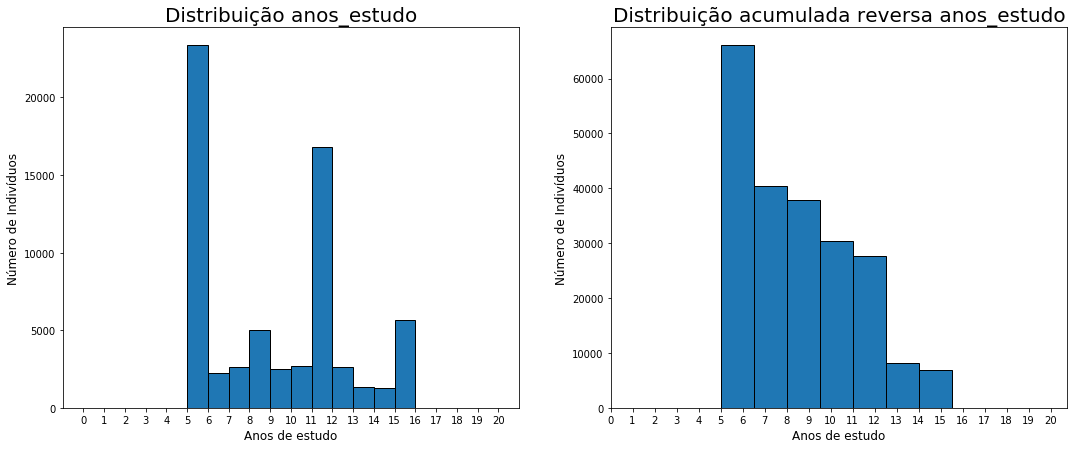

In [5]:
# Visualizando a distribuição:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

ax[0].hist(df.anos_estudo.dropna(), bins=20, range=(0, 20), ec=HIST_ec)

utils.set_plot_details(axs=ax[0],
                       title='Distribuição anos_estudo',
                       title_fontsize=20,
                       xticks=range(0, 21),
                       xlabel='Anos de estudo',
                       xlabel_fontsize=12,
                       ylabel='Número de Indivíduos',
                       ylabel_fontsize=12)

ax[1].hist(df.anos_estudo.dropna(), cumulative=-
           1, bins=10, range=(5, 20), ec=HIST_ec)

utils.set_plot_details(axs=ax[1],
                       title='Distribuição acumulada reversa anos_estudo',
                       title_fontsize=20,
                       xticks=range(0, 21),
                       xlabel='Anos de estudo',
                       xlabel_fontsize=12,
                       ylabel='Número de Indivíduos',
                       ylabel_fontsize=12)

plt.show()

&rarr; Aqui vale um comentário mais detalhado. Alguns pontos a serem observados:

1) A ocorrência dos picos no primeiro histograma deve-se aos ciclos de ensino no Brasil. 5 anos corresponde ao Ensino Fundamental I completo, 8 anos corresponde ao Ensino Fundamental II completo, 11 anos de estudo correspondem ao Ensino Médio completo e 14 e 15 anos de estudo correspondem ao Ensino Superior Completo.

2) O segundo histograma representa a distribuição acumulada, ou seja, quantos indivíduos têm pelo menos X anos de estudo, já que  quem estudou por 6 anos também estudou por 5 e assim por diante.

3) Em um país como o Brasil, em que 7% da população ainda é analfabeta (PNAD 2017), parece estranho que, em uma amostra com 66000 observações, nenhum indivíduo tenha menos do que 5 anos de estudo. Da mesma forma, parece estranho que nenhum indivíduo tenha mais do que 15 anos de estudo. Isso indica um viés em potencial na pesquisa.



In [6]:
# Nulos:
null_percentage = df['anos_estudo'].isnull().sum()/df.shape[0] * 100
print(
    'Os valores nulos correspondem a apenas {:.2f}% dos valores da coluna \'anos_estudo\'.'.format(null_percentage))

Os valores nulos correspondem a apenas 0.65% dos valores da coluna 'anos_estudo'.


In [7]:
# Como os valores nulos correspondem a uma fração muito pequena do Dataset,
# vamos optar por desconsiderá-los uma vez que não é possível inferir a que se referem.
df.dropna(subset=['anos_estudo'], inplace=True)

### Explorando 'região'

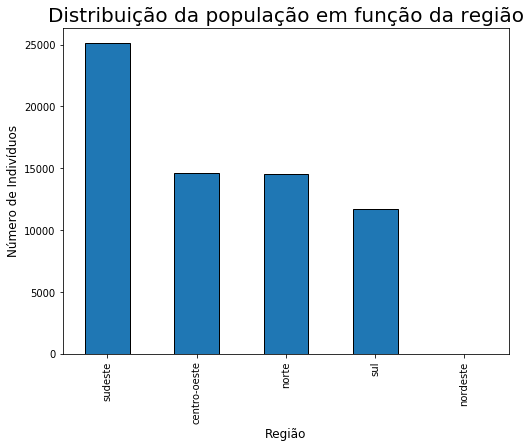

In [8]:
# Visualizando a distribuição de indivíduos nas regiões do Brasil na amostra:
fig, ax = plt.subplots(figsize=(8, 6))

df.regiao.value_counts().plot(ax=ax, kind='bar', ec=HIST_ec)

utils.set_plot_details(axs=ax,
                       title='Distribuição da população em função da região',
                       title_fontsize=20,
                       xlabel='Região',
                       xlabel_fontsize=12,
                       ylabel='Número de Indivíduos',
                       ylabel_fontsize=12)

plt.show()

&rarr; Aqui podemos perceber mais um problema da amostra. Pouquíssimos indivíduos da região nordeste. Mais uma prova de que essa amostra é enviesada e não é representativa da população brasileira.

In [9]:
df.regiao.value_counts()

sudeste         25111
centro-oeste    14652
norte           14555
sul             11713
nordeste            5
Name: regiao, dtype: int64

De fato, apenas 5 indivíduos da região Nordeste. Como essa quantidade de indivíduos não é nem um pouco representativa, vamos optar por excluir a região das análises. Assim:

In [10]:
# Removendo a região nordeste:
df = df.loc[df['regiao']!='nordeste']

### Explorando anos_estudo vs região:

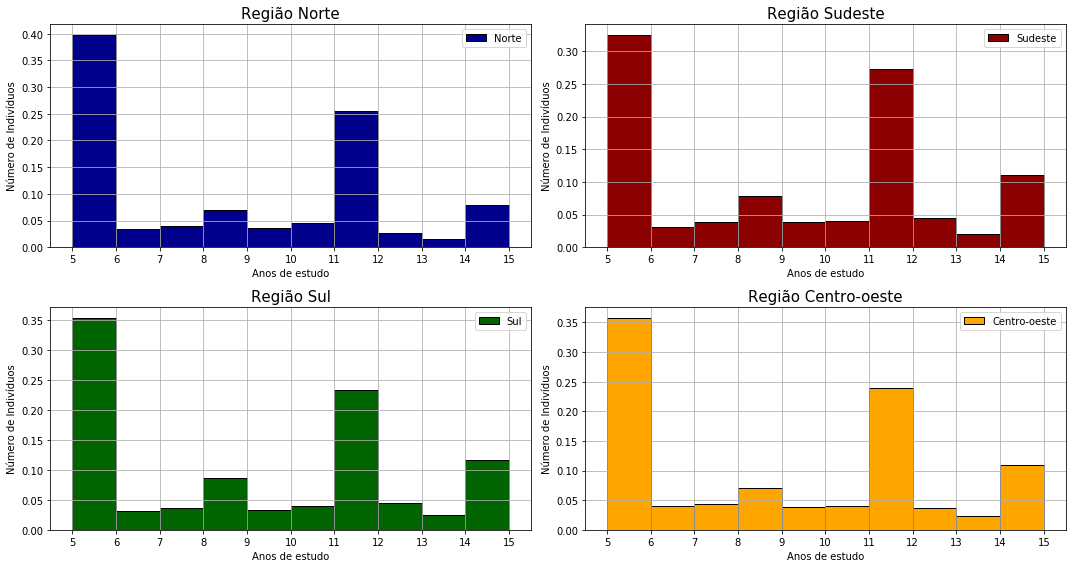

In [11]:
regions = iter(df.regiao.unique())
colors = iter(['darkblue', 'darkred', 'darkgreen', 'orange'])
fig, axs = plt.subplots(2, 2, figsize=(15, 8))

for ax in axs.flat:
    region = next(regions)
    color_ = next(colors)

    ax.hist(df.loc[df['regiao'] == region, 'anos_estudo'],
            bins=10, ec=HIST_ec, density=True, color=color_)

    utils.set_plot_details(axs=ax,
                           title='Região '+region.capitalize(),
                           title_fontsize=15,
                           xticks=range(5, 16),
                           xlabel='Anos de estudo',
                           ylabel='Número de Indivíduos',
                           grid=True,
                           legend=[region.capitalize()])

plt.tight_layout()
plt.show()

&rarr; Os histogramas dispostos acima são normalizados pelo tamanho da amostra, de forma que nos permitem comparar as distribuições das regiões. Novamente os picos se repetem nos anos que marcam fins dos ciclos de educação. Podemos notar, por exemplo, que a proporção de indivíduos que fizeram apenas o Ensino Fundamental I é maior na região Norte, com relação as demais. Além disso, pode-se perceber que, talvez como consequência da situação descrita, a proporção de indivíduos que conclui o ensino superior na região Norte é menor que nas demais. Aparentemente, a região cuja população mais conclui o ensino superior parece ser a região Sul, ainda que a diferença com relação a Sudeste e Centro-Oeste seja muito pequena.

## Análise Estatística:

Já vimos que a amostra da qual dispomos não é representativa da população brasileira, uma vez não há muitos indivíduos da região nordeste e os anos de estudo não estão bem distribuídos. Contudo, para efeito didático, vamos considerar como se a amostra fosse representativa e seguir com a análise.

### Teorema do Limite Central (TLC):

Conforme vimos nos histogramas plotados anteriormente, a distribuição da população em função do número de anos de estudo não se comporta como uma distribuição normal. Contudo, os testes estatísticos mais robustos têm como premissa que a distribuição seja uma distribuição normal.

O Teorema do Limite Central surge para ajudar nesse sentido. Segundo este teorema, dada uma população, se tomarmos um número suficientemente grande de amostras (n_sample) de tamanho suficientemente grande (sample_size), a distribuição das médias de cada amostra se comportará como uma distribuição normal, cuja média se aproxima da média da população e cujo desvio padrão se aproxima do desvio padrão da população dividido pelo tamanho da amostra.

No nosso caso, usaremos o Teorema do Limite Central para criar uma distribuição normal que represente a distribuição de anos de estudo da população brasileira e também para criar distribuições normais que representam os anos de estudo das populações de cada uma das quatro regiões analisadas.

In [12]:
# Instanciando analisador que contém as funções a serem utilizadas a seguir:
anl = utils.Stat_Analizer_TLC(alpha=0.95, sample_size=500, n_sample=10000)

In [13]:
# Transformando as distribuições em distribuições normais via TLC
dist_brasil = anl.sample_means(df['anos_estudo'])

dist_norte = anl.sample_means(df.loc[df['regiao'] == 'norte', 'anos_estudo'])

dist_co = anl.sample_means(
    df.loc[df['regiao'] == 'centro-oeste', 'anos_estudo'])

dist_sul = anl.sample_means(df.loc[df['regiao'] == 'sul', 'anos_estudo'])

dist_sudeste = anl.sample_means(
    df.loc[df['regiao'] == 'sudeste', 'anos_estudo'])

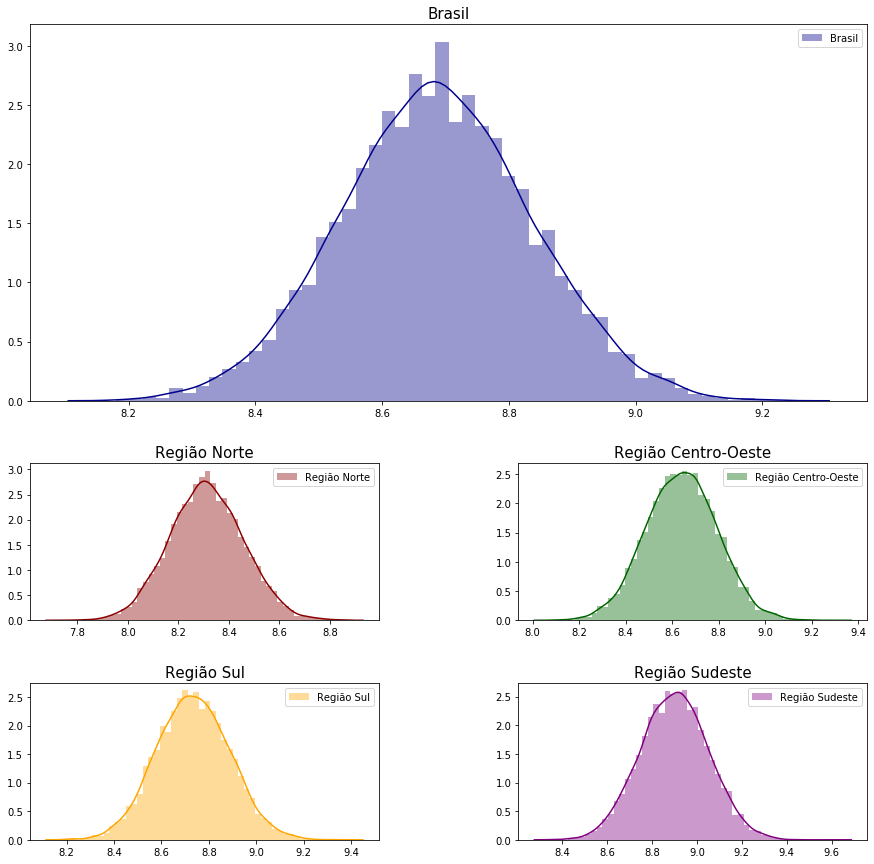

In [14]:
# Visualizando as novas distribuições:

# Definindo iteráveis
distribuitions = [dist_brasil, dist_norte, dist_co, dist_sul, dist_sudeste]
colors = ['darkblue', 'darkred', 'darkgreen', 'orange', 'purple']
regions = ['Brasil', 'Região Norte',
           'Região Centro-Oeste', 'Região Sul', 'Região Sudeste']
ax = {}

# Criando o plot grid
plt.figure(figsize=(15, 15))
grid = plt.GridSpec(4, 2, hspace=0.4, wspace=0.4)

ax[0] = plt.subplot(grid[0:2, 0:2])
ax[1] = plt.subplot(grid[2, 0])
ax[2] = plt.subplot(grid[2, 1])
ax[3] = plt.subplot(grid[3, 0])
ax[4] = plt.subplot(grid[3, 1])

# Plotando as distribuições
for i in range(len(distribuitions)):
    sns.distplot(distribuitions[i], ax=ax[i], color=colors[i], norm_hist=True)

    utils.set_plot_details(axs=ax[i],
                           title=regions[i],
                           title_fontsize=15,
                           legend=[regions[i]])

In [15]:
# Verificando a curtose das distribuições:
for i in range(len(distribuitions)):
    anl.kurtosis_check(dist=distribuitions[i], title=regions[i])

Distribuição de Brasil: Curtose = 2.955
Distribuição de Região Norte: Curtose = 3.015
Distribuição de Região Centro-Oeste: Curtose = 2.982
Distribuição de Região Sul: Curtose = 2.964
Distribuição de Região Sudeste: Curtose = 2.959


Agora sim as distribuições se aproximam mais de distribuições normais, como evidenciado pelos plots e pela verificação da curtose (lembrando que a curtose da distribuição normal é 3,0) e podemos seguir com a aplicação de testes estatísticos.

### Testes estatísticos:

Dispondo de distribuições normais, vamos agora aplicar um teste t comparando as médias da região com a média da população brasileira e, em seguida, aplicar um novo teste t comparando as regiões entre si.

As regiões do Brasil podem ser interpretadas como amostras da população brasielira, então, no primeiro caso, usaremos uma modalidade do teste t que compara a amostra com a população.

Já a comparação entre regiões, trata-se de uma modalidade do teste t para comparação de amostras independentes. Como elas são derivadas da mesma população, adotaremos como verdadeira a hipótese de que a variância das populações de origem são idênticas.

Vamos aos testes!

#### Testando regiões contra a população brasileira:

In [16]:
# Realizando teste t para comparação das regiões com a populaçõo nacional:
for i in range(1, 5):
    anl.perform_t_test_1_sample(distribuitions[i], dist_brasil, regions[i])
    
    if i < 4:
        print('\n')

>>> Região Norte:
Média: 8.312
Intervalo de confiança: 8.664 <------------> 8.707
p-valor = 0.000
Resultado:  A amostra é estatisticamente diferente da população! (rejeitamos a hipótese nula).


>>> Região Centro-Oeste:
Média: 8.641
Intervalo de confiança: 8.664 <------------> 8.707
p-valor = 0.000
Resultado:  A amostra é estatisticamente diferente da população! (rejeitamos a hipótese nula).


>>> Região Sul:
Média: 8.734
Intervalo de confiança: 8.664 <------------> 8.707
p-valor = 0.000
Resultado:  A amostra é estatisticamente diferente da população! (rejeitamos a hipótese nula).


>>> Região Sudeste:
Média: 8.900
Intervalo de confiança: 8.664 <------------> 8.707
p-valor = 0.000
Resultado:  A amostra é estatisticamente diferente da população! (rejeitamos a hipótese nula).


Conforme evidenciado pelo teste acima, podemos afirmar, com 95% de certeza, que a média de anos de estudo das populações de cada região é estatisticamente diferente da média nacional. Mais do que isso, a partir dos resultados obtidos, podemos afimar que a média de anos de estudo das regiões sul e sudeste é superior à média nacional, uma vez que a média das distribuições é mais alta que o limite superior do intervalo de confiança delimitado a partir da distribuição nacional. Além disso, podemos inferir também que a média de anos de estudo das regiões norte e centro-oeste é mais baixa que a média nacional, dado que as médias das distribuições dessas regiões é menor que o limite inferior do referido intervalo de confiança.

#### Testando as regiões entre si:

In [17]:
# Aplicando o teste t para as regiões tomadas aos pares:
from itertools import combinations

for i, j in combinations(range(1, len(distribuitions)), 2):
    anl.perform_t_test_2_sample(
        dist1=distribuitions[i], dist2=distribuitions[j], title1=regions[i], title2=regions[j])
    
    if i > 4:
        print('\n')

Analisando Região Norte contra Região Centro-Oeste:
>>> Região Norte:
Média: 8.312
Intervalo de confiança: 8.291 <------------> 8.333
>>> Região Centro-Oeste:
Média: 8.641
Intervalo de confiança: 8.619 <------------> 8.663
>>> Resultado:
p-valor = 0.000
Conclusão:  As amostra são estatisticamente diferentes entre si! (rejeitamos a hipótese nula).
Analisando Região Norte contra Região Sul:
>>> Região Norte:
Média: 8.312
Intervalo de confiança: 8.291 <------------> 8.333
>>> Região Sul:
Média: 8.734
Intervalo de confiança: 8.712 <------------> 8.756
>>> Resultado:
p-valor = 0.000
Conclusão:  As amostra são estatisticamente diferentes entre si! (rejeitamos a hipótese nula).
Analisando Região Norte contra Região Sudeste:
>>> Região Norte:
Média: 8.312
Intervalo de confiança: 8.291 <------------> 8.333
>>> Região Sudeste:
Média: 8.900
Intervalo de confiança: 8.879 <------------> 8.922
>>> Resultado:
p-valor = 0.000
Conclusão:  As amostra são estatisticamente diferentes entre si! (rejeitamos

De fato, as regiões também são estatisticamente diferentes entre si, como evidenciado pelo Teste t. 

## Conclusão:

A partir das análises realizadas acima, podemos, finalmmente, responder à pergunta proposta no objetivo: Sim, as regiões do Brasil apresentam escolaridades média diferentes da média nacional e também diferentes entre si. A região Sudeste e a região Sul apresentam escolaridades acima da média nacional, enquanto que as regiões Centro-Oeste e Norte apresentam escolaridade abaixo da média nacional. Além disso, podemos rankear as regiões de acordo com a escolaridade média de sua população, como abaixo:

1) Região Sudeste: média de anos de estudo da população: 8,9 anos;

2) Região Sul: média de anos de estudo da população: 8,7 anos;

3) Região Centro-Oeste: média de anos de estudo da população: 8,6 anos;

4) Região Norte: média de anos de estudo da população: 8,3 anos;

Nada pôde ser inferido com relação à região Nordeste por causa de um problema de amostragem, dado que a amostra populacional contava com apenas 5 indíviduos da referida região.